#Problem 3: Learning a data-driven Linear Dynamical System (LDS)

##Part C:
Repeat part B but consider only the top 6 principal components of each matrix X.
REMEMBER: PCA projection includes a mean subtraction step! This is very important in projecting the data! Compute again the reconstruction error of the data given the learned dynamical system (with a one-step prediction), and plot the histogram of errors.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


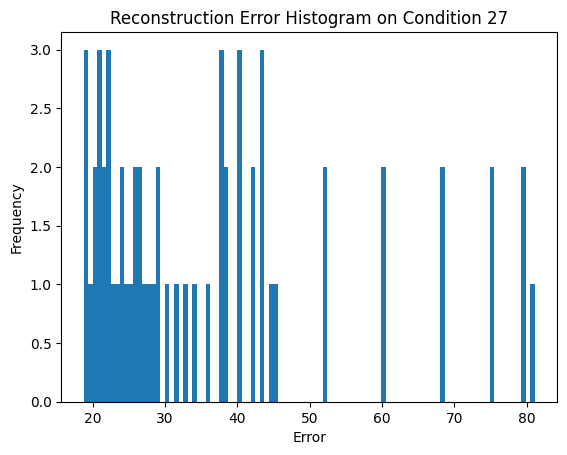

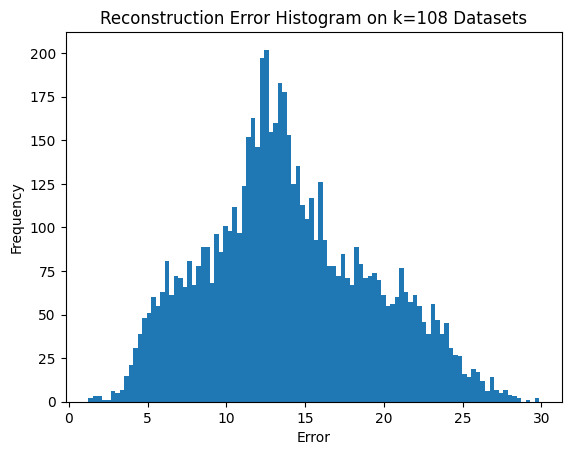

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Find the file in google drive
drive.mount('/content/drive')
file = "/content/drive/MyDrive/Neural_Signals_and_Computation_HW2/exampleData.mat"

import scipy.io as sio
mat_contents = sio.loadmat(file)
data = mat_contents['Data']
# Data is the struct (length = 1)
# Data[c] is the condition (length = 108)
# Data[c][o] are the fields options (length = 2)
# Data[c][o][0] is the A matrix (shape = (61, 218))
# Data[c][o][1] is the time (shape = (61, 1))

# Repeat what we did in B, use PCA on data matrix before dynamics analysis
def do_pca(data_matrix, num_components=6):
  pca = PCA(n_components=num_components)
  data_mean = np.mean(data_matrix, axis=0)
  data_centered = data_matrix - data_mean
  data_reduced = pca.fit_transform(data_centered)
  return data_reduced, pca, data_mean

condition27 = data[0][27]
cond27_A = condition27[0]
cond27_A, pca27, mean27 = do_pca(cond27_A)
cond27_A = cond27_A.transpose()
cond27_t = condition27[1]

# Calculate the discrete matrix dx/dt
dx_dt = []
xt = []
for i in range(cond27_A.shape[1] - 1):
  current = cond27_A[:,i + 1]
  prev = cond27_A[:,i]
  current_t = cond27_t[i + 1]
  prev_t = cond27_t[i]

  dx_dt.append((current - prev) / (current_t - prev_t))
  xt.append(current)

xt = np.array(xt)
dx_dt = np.array(dx_dt)
A_estimated27 = np.linalg.lstsq(xt, dx_dt, rcond=None)[0]

# Reconstruction
errors = []
for t in range(1, cond27_A.shape[1]):
  x_pred = cond27_A[:,t-1] + (cond27_t[t] - cond27_t[t-1]) * np.matmul(A_estimated27, cond27_A[:,t-1])
  x_pred_original = pca27.inverse_transform(x_pred) + mean27
  x_true_original = pca27.inverse_transform(cond27_A[:,t]) + mean27
  error = np.linalg.norm(x_pred_original - x_true_original)
  errors.append(error)

# Plot the histogram of errors
plt.hist(errors, bins=100)
plt.title('Reconstruction Error Histogram on Condition 27')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Now for k datasets
dx_dt = []
xt = []

conds = []
pcas = []
means = []
times = []
for k in range(len(data[0])):
  condition_k = data[0][k]
  cond_A, pca_k, mean_k = do_pca(condition_k[0])
  cond_A = cond_A.transpose()
  conds.append(cond_A)
  pcas.append(pca_k)
  means.append(mean_k)
  cond_t = condition_k[1]
  times.append(cond_t)

  for i in range(cond_A.shape[1] - 1):
    current = cond_A[:,i + 1]
    prev = cond_A[:,i]
    current_t = cond_t[i + 1]
    prev_t = cond_t[i]

    dx_dt.append((current - prev) / (current_t - prev_t))
    xt.append(current)

xt = np.array(xt)
dx_dt = np.array(dx_dt)

A_estimated_k = np.linalg.lstsq(xt, dx_dt, rcond=None)[0]

# Reconstruction
errors = []
for i in range(len(data[0])):
  cond_A = conds[i]
  pca = pcas[i]
  mean = means[i]
  cond_t = times[i]
  for t in range(1, cond_A.shape[1]):
    x_pred = cond_A[:,t-1] + (cond_t[t] - cond_t[t-1]) * np.matmul(A_estimated_k, cond_A[:,t-1])
    x_pred_original = pca.inverse_transform(x_pred) + mean
    x_true_original = pca.inverse_transform(cond_A[:,t]) + mean
    error = np.linalg.norm(x_pred_original - x_true_original)
    errors.append(error)

# Plot the histogram of errors
plt.hist(errors, bins=100)
plt.title('Reconstruction Error Histogram on k=108 Datasets')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()